<a href="https://colab.research.google.com/github/hopeof-Greatmind/Yolov12-Training/blob/main/yolov12_train_object_detection_model_customdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on your Custom Dataset

---

[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is the latest model in the YOLO series, developed by Yunjie Tian, Qixiang Ye, David Doermann and introduced in the paper [YOLOv12: Attention-Centric Real-Time Object Detectors](https://arxiv.org/abs/2502.12524).

This model achieves both lower latency and higher mAP than previous state-of-the-art models like YOLOv11, YOLOv10, and RT-DETR.

<img src="https://raw.githubusercontent.com/sunsmarterjie/yolov12/main/assets/tradeoff.svg" width=100%>

In this guide, we are going to walk through how to fine-tune a YOLOv12 model on a custom dataset.

Without further ado, let's get started!

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv12
- Download pre-trained weights
- Download example data
- Inference with Pre-trained COCO Model
- Download dataset from Roboflow Universe
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Tue Sep  2 09:29:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install supervision flash-attn --upgrade -q
# # import os
# # os.environ['CUDA_FORCE_FP16'] = '0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 61.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 1.1 MB/s eta 0:00:00


## Install YOLOv12 from Source

**NOTE:** Currently, YOLOv12 does not have its own PyPI package. Therefore, we need to install the code from the source.

You can install YOLOv12 with the code below:

In [ ]:
!git clone https://github.com/sunsmarterjie/yolov12
#!git clone https://github.com/ultralytics/yolov12
%cd yolov12
# !pip install roboflow supervision flash-attn --upgrade -q
!pip install -r requirements.txt
!pip install -e ./''


Cloning into 'yolov12'...
remote: Enumerating objects: 1159, done.
remote: Counting objects: 100% (479/479), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 1159 (delta 324), reused 296 (delta 296), pack-reused 680 (from 2)
Receiving objects: 100% (1159/1159), 1.81 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (580/580), done.
/content/yolov12
ERROR: flash_attn-2.7.3+cu11torch2.2cxx11abiFALSE-cp311-cp311-linux_x86_64.whl is not a supported wheel on this platform.
Obtaining file:///content/yolov12
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ultralytics (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.63-0.editable-py3-none-any.whl size=20234 sha256=885a4cd5c50e3a7d45ab26f153ce138c09d40ccceef4b44255e9b2cbc5d8ae2d
  Stored in directory: /tmp/pip-

## Configuration & Download example data

In [ ]:
!pip install ultralytics supervision opencv-python torch torchvision torchaudio flash-attn --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 78.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.6 MB/s eta 0:00:00


Next, let's download an example image of a person and a dog that we can use to test our model:

In [ ]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-09-02 09:53:01--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg.1’

dog.jpeg.1          100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-09-02 09:53:01 (110 MB/s) - ‘dog.jpeg.1’ saved [106055/106055]




0: 640x384 1 person, 1 car, 1 dog, 1 backpack, 1945.7ms
Speed: 2.1ms preprocess, 1945.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


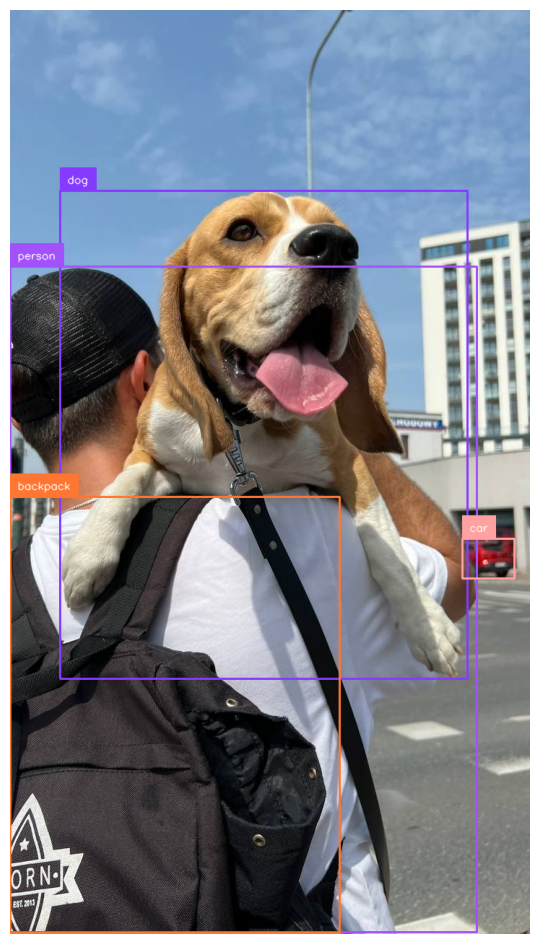

In [ ]:
import os

# ✅ Disable FlashAttention (if on older GPUs)
os.environ["FLASHATTN_DISABLED"] = "1"

# ✅ Force CPU mode if GPU is incompatible
import torch
device = "cuda" if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8 else "cpu"

# ✅ Import necessary libraries
from ultralytics import YOLO
import supervision as sv
import cv2

# ✅ Load image
image_path = "dog.jpeg"  # Replace with your image path
image = cv2.imread(image_path)

# ✅ Load YOLO model and move to appropriate device
model = YOLO("yolov12x.pt").to(device)

# ✅ Perform inference
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

# ✅ Annotate results
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# ✅ Display annotated image
sv.plot_image(annotated_image)

## Run inference

Let's run the `yolov12n` base model that was trained using the Microsoft COCO dataset. This model comes out of the box with YOLOv12.

We will then use the Roboflow `supervision` Python package to visualize the results from our model.


0: 640x384 1 person, 1 car, 1 dog, 1 backpack, 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


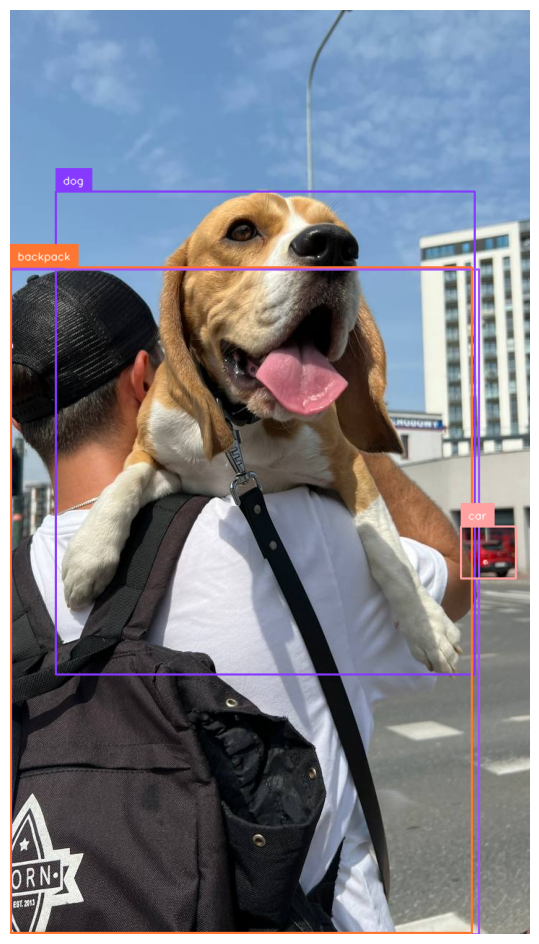

In [ ]:
import os
os.environ["TORCH_USE_CUDA_FP16"] = "0"
from ultralytics import YOLO
import supervision as sv
import cv2

image = cv2.imread("dog.jpeg")

model = YOLO('yolov12n.pt')
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

The YOLOv12 model successfully identifies the person and dog in the image.

You can experiment with different model sizes by replacing `yolov12n.pt` with:

- yolov12n.pt
- yolov12s.pt
- yolov12m.pt
- yolov12l.pt
- yolov12x.pt

## Train a model

Now, let's fine-tune a YOLOv12 model using a custom dataset.

For this guide, we will use a yard management dataset hosted on Roboflow Universe. This dataset contains images of shipping containers and other industrial objects.

We will:

- Download the dataset
- Train the model
- View the trained model confusion matrix
- Run our model on an image

### Download dataset from Roboflow Universe

If you do not already have one, create a [free Roboflow account](https://app.roboflow.com). When you run the code below, you will be asked for your API key. This will allow you to export the dataset we will use for training.

You can use any dataset in the [YOLOv8 PyTorch TXT format](https://roboflow.com/formats/yolov8-pytorch-txt).

In [ ]:
!pip install roboflow --upgrade -q # Install the roboflow library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.6 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
from roboflow import Roboflow

#ROBOFLOW_API_KEY = userdata.get('MMQccvY9HKjgRLQzIwLO')

rf = Roboflow(api_key="MMQccvY9HKjgRLQzIwLO")
project = rf.workspace("bg-kim-sookmyung-ac-kr").project("pokercard_2023")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to PokerCard_2023-1 in yolov8:: 100%|██████████| 525/525 [00:00<00:00, 1561.89it/s]


In [ ]:
!ls
!pwd

app.py	  dog.jpeg.1  mkdocs.yml	requirements.txt      yolov12n.pt
assets	  examples    PokerCard_2023-1	tests		      yolov12x.pt
docker	  LICENSE     pyproject.toml	ultralytics
dog.jpeg  logs	      README.md		ultralytics.egg-info
/content/yolov12


We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following code to prepare your dataset for training:

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [ ]:
# Inspect the data.yaml file to get the correct class names
!ls /content/yolov12/PokerCard_2023-1/valid/labels/
!cat /content/yolov12/PokerCard_2023-1/valid/data.yaml

cam_image10_jpg.rf.75efa2567f99b259646c28b364e8c112.txt
cam_image14_jpg.rf.87d5d51c9ac9fafb268764d98fa6a6ea.txt
cam_image22_jpg.rf.0b5f1b4fa9c0bae9fd3fa8bda8716590.txt
cam_image24_jpg.rf.38b564c05638f39f9e619ea0344bfea5.txt
cam_image26_jpg.rf.70dcbbb69b00d3f2eaadd6397bda6c72.txt
cam_image29_jpg.rf.f7cc453a2dabaa6ba62878a8488e686c.txt
cam_image30_jpg.rf.0cce4f085e9c4459ec4e9077d3b8c0ba.txt
cam_image34_jpg.rf.6e910e594acb4bf3f66a81e2e6c8761a.txt
cam_image43_jpg.rf.248607f0c465dd14656b001742d78f8a.txt
cam_image44_jpg.rf.8f5d92cedab7fdbd64f5dcaa4382b329.txt
cam_image47_jpg.rf.0c6c46e5eaac7c8775253638a55711e5.txt
cam_image52_jpg.rf.49ba8fa823b200b9f1b612cd598ce9ab.txt
cam_image54_jpg.rf.4e791646fd23e12f9d478e1154170c73.txt
IMG_2392_JPG.rf.5c58759f6fec5aae696eff67f98c7a54.txt
IMG_2399_JPG.rf.408d3dc0138ea5019c1c0f9f9e869e0b.txt
IMG_2431_JPG.rf.0be6d1a4de891184ddc6647232d3fbce.txt
IMG_2441_JPG.rf.48b56de1f97232d2ead9888a645d1e56.txt
IMG_2443_JPG.rf.1087e998024e0d0610d7771be1a5792a.txt
IMG_244

### Train the model

We are now ready to train a YOLOv12 model.

Below, repalce `yolov12s.yaml` with the checkpoint from which you want to start training. You can use:

- yolov12n.pt
- yolov12s.pt
- yolov12m.pt
- yolov12l.pt
- yolov12x.pt

We recommend training for at least 250 epochs.

Once you have set your training checkpoint, run the code cell below to start training.

**Note ⚠️:** After all epochs run, the `model()` will return a `TypeError: argument of type 'PosixPath' is not iterable` error. This has been [filed as an issue](https://github.com/sunsmarterjie/yolov12/issues/2). If you see this error after training, your model weights will still be saved and you can safely proceed to running inference.

In [18]:
from ultralytics import YOLO

model = YOLO('yolov12m.yaml')

results = model.train(
  data=f'{dataset.location}/data.yaml',
  epochs=250
)

New https://pypi.org/project/ultralytics/8.3.191 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12m.yaml, data=/content/yolov12/PokerCard_2023-1/data.yaml, epochs=250, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning /content/yolov12/PokerCard_2023-1/train/labels.cache... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/yolov12/PokerCard_2023-1/valid/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]


Plotting labels to /content/yolov12/runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 131 weight(decay=0.0), 138 weight(decay=0.0005), 137 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolov12/runs/detect/train2
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      13.7G      3.218       4.75      4.494          4        640: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250        13G      3.125      4.746      4.324          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      12.8G       3.19      4.472      4.171          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         21         33          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250        13G      3.086      4.414      4.048          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      13.1G      3.091      4.181      3.902          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         21         33          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      13.1G      2.967      4.013      3.795          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         33   0.000362      0.153   0.000906    0.00021



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      12.7G      2.914      3.929      3.654          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33     0.0014      0.271     0.0113    0.00158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      12.8G      2.759      3.777       3.51          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33     0.0273      0.413      0.104     0.0242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      13.1G      2.679      3.573      3.401          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         21         33      0.811     0.0833      0.138     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      12.8G      2.685      3.535      3.327          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33      0.836     0.0278    0.00337   0.000536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      12.7G      2.618      3.252      3.212          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.835     0.0556    0.00177   0.000347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      12.8G      2.499      3.143      3.136          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33      0.738      0.111     0.0917     0.0272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250        13G      2.445      2.986      3.112          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         21         33      0.542      0.132     0.0186    0.00676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      12.8G      2.446      2.932      3.093          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.079      0.335     0.0612     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      12.8G      2.296      2.925      2.965          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33      0.123      0.149      0.104     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      12.8G      2.157      2.657      2.867          7        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.576      0.382      0.453       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      13.1G      2.136       2.68      2.799          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         21         33      0.868       0.36       0.54      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      12.8G      1.855      2.626      2.547          0        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33      0.368      0.742      0.525      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      12.7G      1.975      2.462      2.681          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         21         33      0.738      0.312      0.471      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      12.8G       1.93      2.422      2.698          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.298      0.428      0.458       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      13.1G      1.945       2.44      2.622          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.191      0.543      0.339      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      12.8G      1.866      2.259      2.541          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         21         33        0.3      0.426      0.477      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      12.7G      1.927      2.404      2.585          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         21         33      0.234      0.463      0.328      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      12.8G      1.875      2.362      2.543          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33      0.414      0.647      0.511      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      13.4G      1.718      2.108      2.431          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.458      0.602      0.541      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      12.7G      1.811      2.135      2.501          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33      0.522      0.562      0.566      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      12.7G      1.694      2.036       2.38          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33       0.41      0.747      0.587      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      12.8G      1.631      2.122      2.329          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33      0.318      0.504        0.5      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      13.4G      1.664       1.98      2.358          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.409      0.713       0.54      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      12.8G      1.564      1.968       2.26          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.343      0.652      0.519      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      12.7G      1.575      1.877      2.257          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33      0.401      0.731      0.552      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      12.8G      1.576      1.827      2.253          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33      0.489      0.695      0.573      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      13.1G      1.546      1.887      2.185          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.411      0.691       0.52      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      12.8G        1.5      1.787      2.171          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         21         33      0.432      0.703      0.502      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      12.7G      1.463      1.676      2.163          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.454      0.577      0.632      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      12.8G       1.41      1.698      2.105          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33      0.474      0.687       0.59      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250        13G      1.473      1.758      2.138          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         21         33      0.361      0.764      0.604      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      12.8G      1.407      1.761      2.077          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         21         33      0.426      0.763      0.638      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      12.7G       1.35      1.679      2.074          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.455      0.762      0.568      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      12.8G      1.316      1.572      2.035          7        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33       0.39      0.909      0.706      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      13.4G      1.313      1.502      1.989          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.489      0.747      0.669      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      12.8G      1.444      1.681      2.116          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         33      0.621      0.636      0.708      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      12.7G      1.284      1.503      1.966          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         21         33      0.566      0.642      0.648      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      12.8G      1.301      1.508      2.008          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.683      0.563      0.627      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      13.4G      1.271      1.429      1.967          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         21         33        0.5      0.589      0.673      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      12.8G      1.345      1.519      1.995          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.406       0.69      0.606      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      12.7G       1.22      1.432      1.877          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         21         33      0.483      0.815      0.684      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      12.8G      1.241      1.441      1.877          7        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         21         33      0.429      0.807      0.641      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      13.1G       1.24      1.458      1.897          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         21         33      0.633      0.655       0.67      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      12.8G      1.226       1.34      1.899          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.664      0.574      0.708      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      12.7G      1.265      1.379       1.92          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.444      0.736      0.624      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      12.8G      1.274      1.386      1.924          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         21         33      0.546      0.771      0.668      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      13.4G      1.205      1.393      1.856          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.654      0.632      0.695      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      12.8G      1.123      1.258      1.822          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         21         33      0.614      0.684      0.731      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      12.7G       1.23      1.396      1.851          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33       0.59      0.775       0.72      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250      12.8G       1.25       1.36      1.941          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         21         33      0.528      0.818      0.716      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      13.4G      1.228      1.448      1.778          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.462      0.847      0.721      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      12.8G      1.155      1.343      1.808          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.623      0.689      0.742      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      12.7G      1.172      1.322       1.81          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         21         33      0.515      0.714      0.682      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      12.8G      1.181      1.369      1.848          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33       0.44      0.823      0.701      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      13.1G        1.1      1.222       1.73          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         21         33      0.468      0.677      0.649      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      12.8G      1.145      1.247      1.781          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         21         33      0.505      0.684      0.692      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250      12.7G      1.167      1.225      1.778          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         21         33      0.491      0.745      0.714      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      12.8G      1.132      1.353      1.817          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.631      0.866      0.828      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      13.4G      1.242      1.307      1.851          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.602      0.897      0.837      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      12.8G      1.047       1.24      1.645          0        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.547      0.749      0.798      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      12.7G      1.067      1.125      1.736          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.547      0.766      0.742      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      12.8G      1.138        1.2      1.805          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         21         33      0.599      0.815      0.735       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250        13G      1.095      1.117      1.725          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.671      0.725      0.769       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      12.8G      1.042      1.141      1.696          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.605      0.721      0.701      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250      12.7G      1.035      1.124      1.734          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         21         33      0.507      0.785       0.74      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250      12.8G      1.048      1.139      1.705          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.668      0.763       0.81      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      13.1G      1.031      1.241      1.707          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33      0.683      0.801        0.8       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      12.8G      1.051      1.198      1.627          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.765      0.721      0.779      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250      12.7G      1.044      1.128       1.71          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         33      0.771      0.666      0.766      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      12.8G      1.017      1.015      1.645          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         21         33      0.527      0.789      0.738       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      13.1G      1.057      1.151      1.655          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         21         33      0.602      0.853       0.79      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      12.8G     0.9982      1.045      1.656          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         21         33      0.761      0.726      0.851      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      12.7G     0.9999      1.095      1.685          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.687      0.823      0.767      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      12.8G     0.9615     0.9732       1.59          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         21         33      0.602      0.798      0.775      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      13.1G     0.9648     0.9773      1.613          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.736      0.795      0.799      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250      12.8G      0.983      1.094      1.625          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         21         33      0.706      0.745      0.787      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      12.7G       1.07      1.078      1.646          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         21         33      0.688       0.73      0.828      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      12.8G      1.019      1.155      1.634          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.758      0.701      0.809      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      13.1G          1     0.9982      1.626          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33      0.853      0.713      0.819      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250      12.8G     0.9822      1.048       1.58          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         21         33       0.79      0.814      0.846      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250      12.7G     0.9583     0.9898      1.561          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         21         33      0.803      0.741      0.822      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      12.8G       1.03      1.087      1.622          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         21         33       0.69      0.724      0.762      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250      13.4G     0.9447     0.9626      1.593          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         21         33      0.651      0.813      0.805      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250      12.8G      1.013      1.022      1.635          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         21         33      0.721      0.787      0.843      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250      12.8G     0.9779      1.066      1.669          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         21         33      0.534      0.718      0.699      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250      12.8G      0.984      1.005      1.647          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         21         33      0.654      0.788      0.783      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250      13.1G      1.046      1.038      1.656          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         21         33      0.739      0.785      0.809      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      12.8G     0.9887      1.011      1.614         10        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         21         33      0.629      0.771      0.811      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250      12.7G     0.9579      1.061      1.551          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.802       0.72      0.839      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250      12.8G     0.9134     0.9026      1.539          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         21         33      0.711      0.753      0.819      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      13.1G     0.9636     0.9379      1.605          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.745      0.781      0.798      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250      12.8G     0.9481     0.9396      1.588         14        640: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         21         33      0.828      0.644      0.821      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      12.7G     0.9088     0.9581      1.544          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.688      0.774      0.799      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250      12.8G     0.9306     0.9456      1.561          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33       0.72      0.774      0.824      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250        13G     0.9021     0.8585      1.519          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33      0.854      0.734       0.84      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      12.8G     0.9984      1.002      1.609          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.668      0.725      0.758      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      12.7G     0.8811     0.8757      1.531          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.662      0.754      0.801      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250      12.8G     0.9251     0.9041      1.559          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33      0.683      0.806      0.832      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      13.4G      1.006     0.9017      1.702          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33      0.758      0.793      0.801      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250      12.8G     0.9091     0.9946      1.564          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         21         33      0.767      0.923      0.897      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      12.7G     0.8753     0.8607      1.501          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.812      0.729      0.806      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250      12.8G     0.8774     0.8247      1.482          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.753      0.854       0.84      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250      13.4G     0.9288     0.9206      1.547          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.767      0.736      0.851      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250      12.8G     0.8705     0.8168      1.478          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.779      0.797      0.818      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250      12.7G     0.8324     0.9974      1.396          0        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.695      0.833      0.815      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250      12.8G     0.9011      0.873      1.513          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         21         33      0.753      0.832      0.822      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      13.4G     0.9131     0.8902      1.505          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33       0.77      0.821      0.819      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250      12.8G     0.8356     0.7796      1.456          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         21         33      0.716      0.748      0.811      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250      12.7G     0.9763     0.9408      1.529          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33       0.77      0.733      0.779      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250      12.8G     0.9091     0.9206      1.546          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.863      0.747      0.837      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250        13G     0.9391     0.9237       1.55          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         21         33      0.799      0.744      0.845      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      12.8G     0.8778     0.8427      1.527          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.752      0.782      0.769      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      12.7G     0.9428     0.9515       1.53          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         21         33       0.74      0.732      0.802      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      12.8G     0.8633     0.8233      1.484          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33       0.83       0.73      0.822      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      13.1G     0.8286     0.8434      1.445          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.882      0.689      0.855      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250      12.8G     0.8449     0.8784      1.478          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         21         33      0.803       0.82      0.846      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      12.7G     0.8242     0.7709       1.43          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33      0.759      0.784      0.835      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      12.8G     0.8694     0.7868      1.472          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.838      0.678      0.843      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250      13.4G     0.8085      0.974      1.386          0        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.804      0.805      0.853      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250      12.8G     0.8263     0.8375      1.444         12        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         21         33      0.757      0.835      0.821      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250      12.7G     0.8319     0.7739      1.441          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.659      0.909      0.863      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      12.8G     0.9076     0.8396      1.459          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.728      0.819      0.848       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      13.4G     0.7626     0.9146      1.342          0        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.748      0.803      0.817      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250      12.8G     0.9173     0.8441      1.496          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.684      0.813      0.804      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      12.7G      0.849     0.8043      1.428          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.648      0.805      0.801      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250      12.8G     0.7817     0.8194      1.393          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         21         33      0.717      0.847      0.817      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250      13.1G     0.8265     0.8112      1.415          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.818       0.77      0.842      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      12.8G     0.8503     0.7954      1.456          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.714      0.822        0.8      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250      12.7G     0.8163     0.7454       1.42          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.791      0.847      0.814      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      12.8G     0.8354     0.8137      1.401          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.757      0.867      0.827      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      13.1G     0.8207     0.7712      1.458          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         21         33      0.746       0.83      0.876      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250      12.7G     0.8269     0.7464      1.449          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.829      0.846      0.846      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      12.7G     0.9557      1.069      1.604          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.785      0.837      0.839      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250      12.8G     0.8693     0.8122      1.554          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         21         33      0.784       0.86      0.842      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250        13G     0.8206     0.7232      1.425          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.775      0.836      0.836      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      12.8G     0.8409     0.7072       1.46          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.768      0.783      0.842      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250      12.7G     0.7875     0.7209      1.394          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.609      0.867       0.86      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250      12.8G     0.7601      0.716      1.378          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.879      0.834       0.84      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250        13G     0.7469      0.729      1.384          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.889      0.805      0.821      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250      12.8G     0.7982      0.721      1.407          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.751      0.825      0.822      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      12.8G     0.7463     0.6661      1.367          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33       0.79      0.851      0.826      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      12.8G     0.8731     0.7549      1.486          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33       0.87      0.838      0.811      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250      13.1G     0.7641      0.713      1.382          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33      0.761      0.826      0.813      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250      12.8G     0.7769     0.7539       1.41          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         21         33      0.748      0.825      0.812      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250      12.8G     0.7931     0.7545      1.385          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.782      0.849      0.863       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250      12.8G     0.7587     0.6871      1.362          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.663        0.8      0.825      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      13.1G     0.7292     0.6643      1.321          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.852      0.813      0.838      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250      12.8G     0.7918      0.659      1.432          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.827      0.823      0.806      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      12.7G     0.7723     0.7107      1.356          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         21         33      0.819      0.755      0.826      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250      12.8G     0.8365     0.7709      1.441          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33      0.661      0.827      0.832       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250      13.1G     0.8286     0.7342      1.505          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.715      0.834      0.816      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/250      12.7G     0.7085     0.6932       1.35          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         21         33      0.737      0.842      0.819      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/250      12.7G     0.7393     0.6654      1.342          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         21         33      0.854      0.848      0.825      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/250      12.8G     0.7379     0.6883      1.337          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.818      0.845      0.827       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/250      13.1G     0.8128     0.6919      1.398          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.715      0.861      0.814      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/250      12.7G     0.7698     0.6956      1.382          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         21         33      0.774      0.785      0.812      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/250      12.7G     0.8814     0.7092      1.514          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         21         33      0.752      0.819      0.825      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/250      12.8G     0.7665     0.6977      1.406          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.813      0.807      0.895      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/250      13.4G     0.7394     0.7936      1.341          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33      0.773      0.794      0.842      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/250      12.8G       0.73     0.6966      1.356          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         33      0.817       0.73      0.835      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/250      12.7G     0.7361     0.6686      1.359          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         21         33      0.848      0.767      0.825      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/250      12.8G     0.6931      0.768      1.314          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.775      0.846      0.849      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/250      13.1G     0.7418     0.7245       1.38          7        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.825      0.751      0.858      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/250      12.8G     0.7401     0.6544       1.35          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.865      0.746      0.851      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/250      12.7G     0.7419      0.702      1.398          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.764      0.865      0.836      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/250      12.8G      0.792     0.6997      1.383          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.804      0.849      0.834      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/250      13.4G     0.7191     0.7173      1.326          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.785      0.845      0.831      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/250      12.8G     0.7151     0.6952      1.339          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.873      0.729      0.851      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/250      12.7G     0.7154     0.6664      1.334          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         21         33       0.83      0.777      0.833      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/250      12.8G     0.7182     0.7049      1.316          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.797      0.834      0.859      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/250        13G     0.9131     0.8492      1.502          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         21         33      0.764      0.814      0.856      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/250      12.7G     0.7317     0.6399      1.327          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33       0.82      0.787      0.847      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/250      12.7G     0.7086     0.6563      1.292          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.766      0.794      0.826      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/250      12.8G     0.7805     0.7897      1.378          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.731      0.851      0.835      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/250      13.4G     0.7082     0.6567      1.332          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.836      0.779      0.818      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/250      12.8G     0.6435     0.7531      1.212          0        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         21         33      0.751      0.822      0.821      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/250      12.7G     0.7647     0.6758      1.404          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.822       0.78      0.839      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/250      12.8G     0.7303     0.7069      1.364          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         33      0.779      0.787      0.832      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/250      13.1G     0.6841     0.6264      1.294          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.817      0.773      0.835      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/250      12.8G      0.702     0.6647      1.305          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.776      0.819      0.845      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/250      12.7G     0.7363     0.6329      1.336          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33       0.85      0.783      0.839      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/250      12.8G     0.6843     0.6403      1.303          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.837      0.768      0.832      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/250      13.1G     0.6768     0.6148      1.286          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         21         33      0.874      0.759      0.842      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/250      12.7G     0.6789     0.5978      1.286          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.851      0.779      0.849      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/250      12.7G     0.7096     0.6568      1.324          8        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         21         33      0.806      0.877      0.866      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/250      12.8G     0.6888     0.6001      1.308          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.828      0.867      0.847      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/250      13.1G     0.6526     0.5882      1.266          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.821      0.832      0.842       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/250      12.8G     0.7287      0.612      1.381          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.787      0.825      0.828      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/250      12.7G      0.705     0.6451      1.313          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         33       0.79      0.865      0.852      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/250      12.8G     0.6449     0.5877      1.278          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.866      0.757      0.876       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/250        13G     0.7419     0.6543       1.32          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33      0.765      0.789      0.834      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/250      12.8G      0.718     0.6875      1.301          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         21         33      0.818      0.786      0.823       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/250      12.7G     0.7097     0.7387      1.286          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.856      0.777      0.814      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/250      12.8G     0.6647     0.6001      1.315          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33       0.77      0.814      0.801      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/250      13.1G     0.6279     0.5901      1.254          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         21         33      0.822       0.75      0.826      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/250      12.8G     0.7107     0.6327      1.353          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.839      0.799      0.827      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/250      12.7G     0.7852     0.6244      1.437          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.767      0.856      0.827      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/250      12.8G     0.7199     0.6577      1.336          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.829      0.766      0.834      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/250      13.4G     0.7349     0.6909      1.337          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.839      0.762      0.839      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/250      12.8G     0.5875     0.7098      1.167          0        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         33      0.812      0.812       0.82      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/250      12.7G     0.6735     0.5999      1.291          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33      0.822      0.766      0.808       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/250      12.8G     0.6108     0.5318      1.213          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.811      0.782      0.813      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/250        13G      0.728     0.6441      1.332          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.793      0.794      0.827      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/250      12.8G     0.6593     0.5671      1.266          5        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         21         33       0.86      0.748      0.832      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/250      12.7G     0.6464     0.6185      1.264          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.876      0.749      0.841      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/250      12.8G     0.7589     0.7347      1.384          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         21         33      0.873      0.758      0.834       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/250        13G     0.6332      0.575      1.257          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.893      0.753      0.846      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/250      12.8G       0.61     0.5514      1.267          7        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         21         33       0.83      0.853      0.853      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/250      12.7G     0.7417     0.7942       1.38          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.849      0.851      0.843       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/250      12.8G     0.7833     0.8446      1.378          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         21         33      0.818      0.835      0.816      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/250      13.4G     0.5875     0.5853      1.257          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         21         33       0.82      0.807      0.832      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/250      12.8G     0.6922     0.6357      1.403          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.846      0.763        0.8       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/250      12.7G     0.6019     0.5506      1.219          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.825      0.752      0.786      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/250      12.8G     0.6367     0.6512      1.271          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.839      0.771      0.801      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/250      13.1G     0.6231     0.5751      1.252          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         21         33      0.811      0.791      0.798      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/250      12.8G     0.6131     0.5568      1.229          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.835      0.774      0.792      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/250      12.7G     0.6372     0.5485      1.248          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         21         33      0.837      0.773      0.794      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/250      12.8G     0.6125     0.5581       1.24          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         21         33      0.858      0.775      0.813      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/250        13G     0.6559     0.6299      1.255          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         21         33      0.844      0.792      0.828       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/250      12.8G     0.6356     0.5755      1.273          7        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.855      0.775      0.838      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/250      12.7G      0.622     0.5755      1.232          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33      0.805      0.816      0.839       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/250      12.8G     0.6231     0.5628      1.227          9        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         21         33      0.818      0.813      0.829       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/250        13G     0.6052     0.5572      1.232          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.794      0.829      0.816      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/250      12.8G     0.5825     0.5304       1.22          3        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.842      0.795      0.809      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/250      12.7G     0.5778     0.5272      1.215          7        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.849      0.786      0.812      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/250      12.8G     0.5787     0.5274        1.2          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.833      0.798       0.82       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/250      13.1G     0.6544     0.5583      1.268          9        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         21         33      0.874      0.755      0.821      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/250      12.8G     0.6209     0.5506      1.251          6        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         21         33      0.825      0.807      0.822      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/250      12.7G     0.6593      0.646      1.308          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.837      0.796      0.819      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/250      12.8G     0.5732     0.5226      1.202          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.816      0.817      0.821      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/250      13.1G     0.5847     0.5364      1.216          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         21         33      0.809       0.82      0.826      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/250      12.8G     0.5871     0.5272      1.218          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.836      0.786      0.823      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/250      12.7G     0.5896      0.493      1.206          2        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         21         33      0.842      0.782       0.82      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/250      12.8G     0.5722     0.5066      1.188          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         21         33      0.842      0.781      0.828      0.756


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/250        13G     0.4874     0.4431      1.186          1        640: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         21         33      0.753      0.867      0.838      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/250      12.8G     0.4741     0.4319      1.119          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         21         33       0.76      0.852      0.836      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/250      12.7G      0.434     0.3885      1.077          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         21         33      0.869      0.748      0.834      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/250      12.8G     0.5056     0.3878      1.143          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         21         33       0.86      0.746      0.835      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/250        13G     0.4382     0.3654      1.105          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.856      0.746      0.809       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/250      12.7G     0.4649     0.3652       1.13          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         21         33      0.857      0.745      0.808      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/250      12.7G     0.4576     0.4794      1.118          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         21         33      0.864      0.745       0.81      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/250      12.8G     0.4143     0.3323      1.039          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         21         33      0.864      0.748      0.808      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/250        13G     0.4637     0.4064      1.131          1        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         21         33      0.831      0.777      0.823      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/250      12.8G     0.4368     0.3722      1.099          4        640: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         21         33      0.844      0.776      0.817      0.752



250 epochs completed in 1.301 hours.
Optimizer stripped from /content/yolov12/runs/detect/train2/weights/last.pt, 39.8MB
Optimizer stripped from /content/yolov12/runs/detect/train2/weights/best.pt, 39.8MB

Validating /content/yolov12/runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 402 layers, 19,581,154 parameters, 0 gradients, 59.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


                   all         21         33      0.861      0.762      0.876      0.794
                   ace          2          2      0.872        0.5      0.496      0.496
                  jack          5          7          1      0.851      0.964       0.85
                  king          6          6      0.969          1      0.995      0.943
                  nine          5          6      0.775      0.833      0.942      0.864
                 queen          6          8       0.87      0.842      0.967      0.902
                   ten          4          4      0.681      0.544      0.895      0.708
Speed: 0.2ms preprocess, 20.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/yolov12/runs/detect/train2


In [20]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/yolov12/runs/detect/train/

ls: cannot access '{HOME}/yolov12/runs/detect/train/': No such file or directory


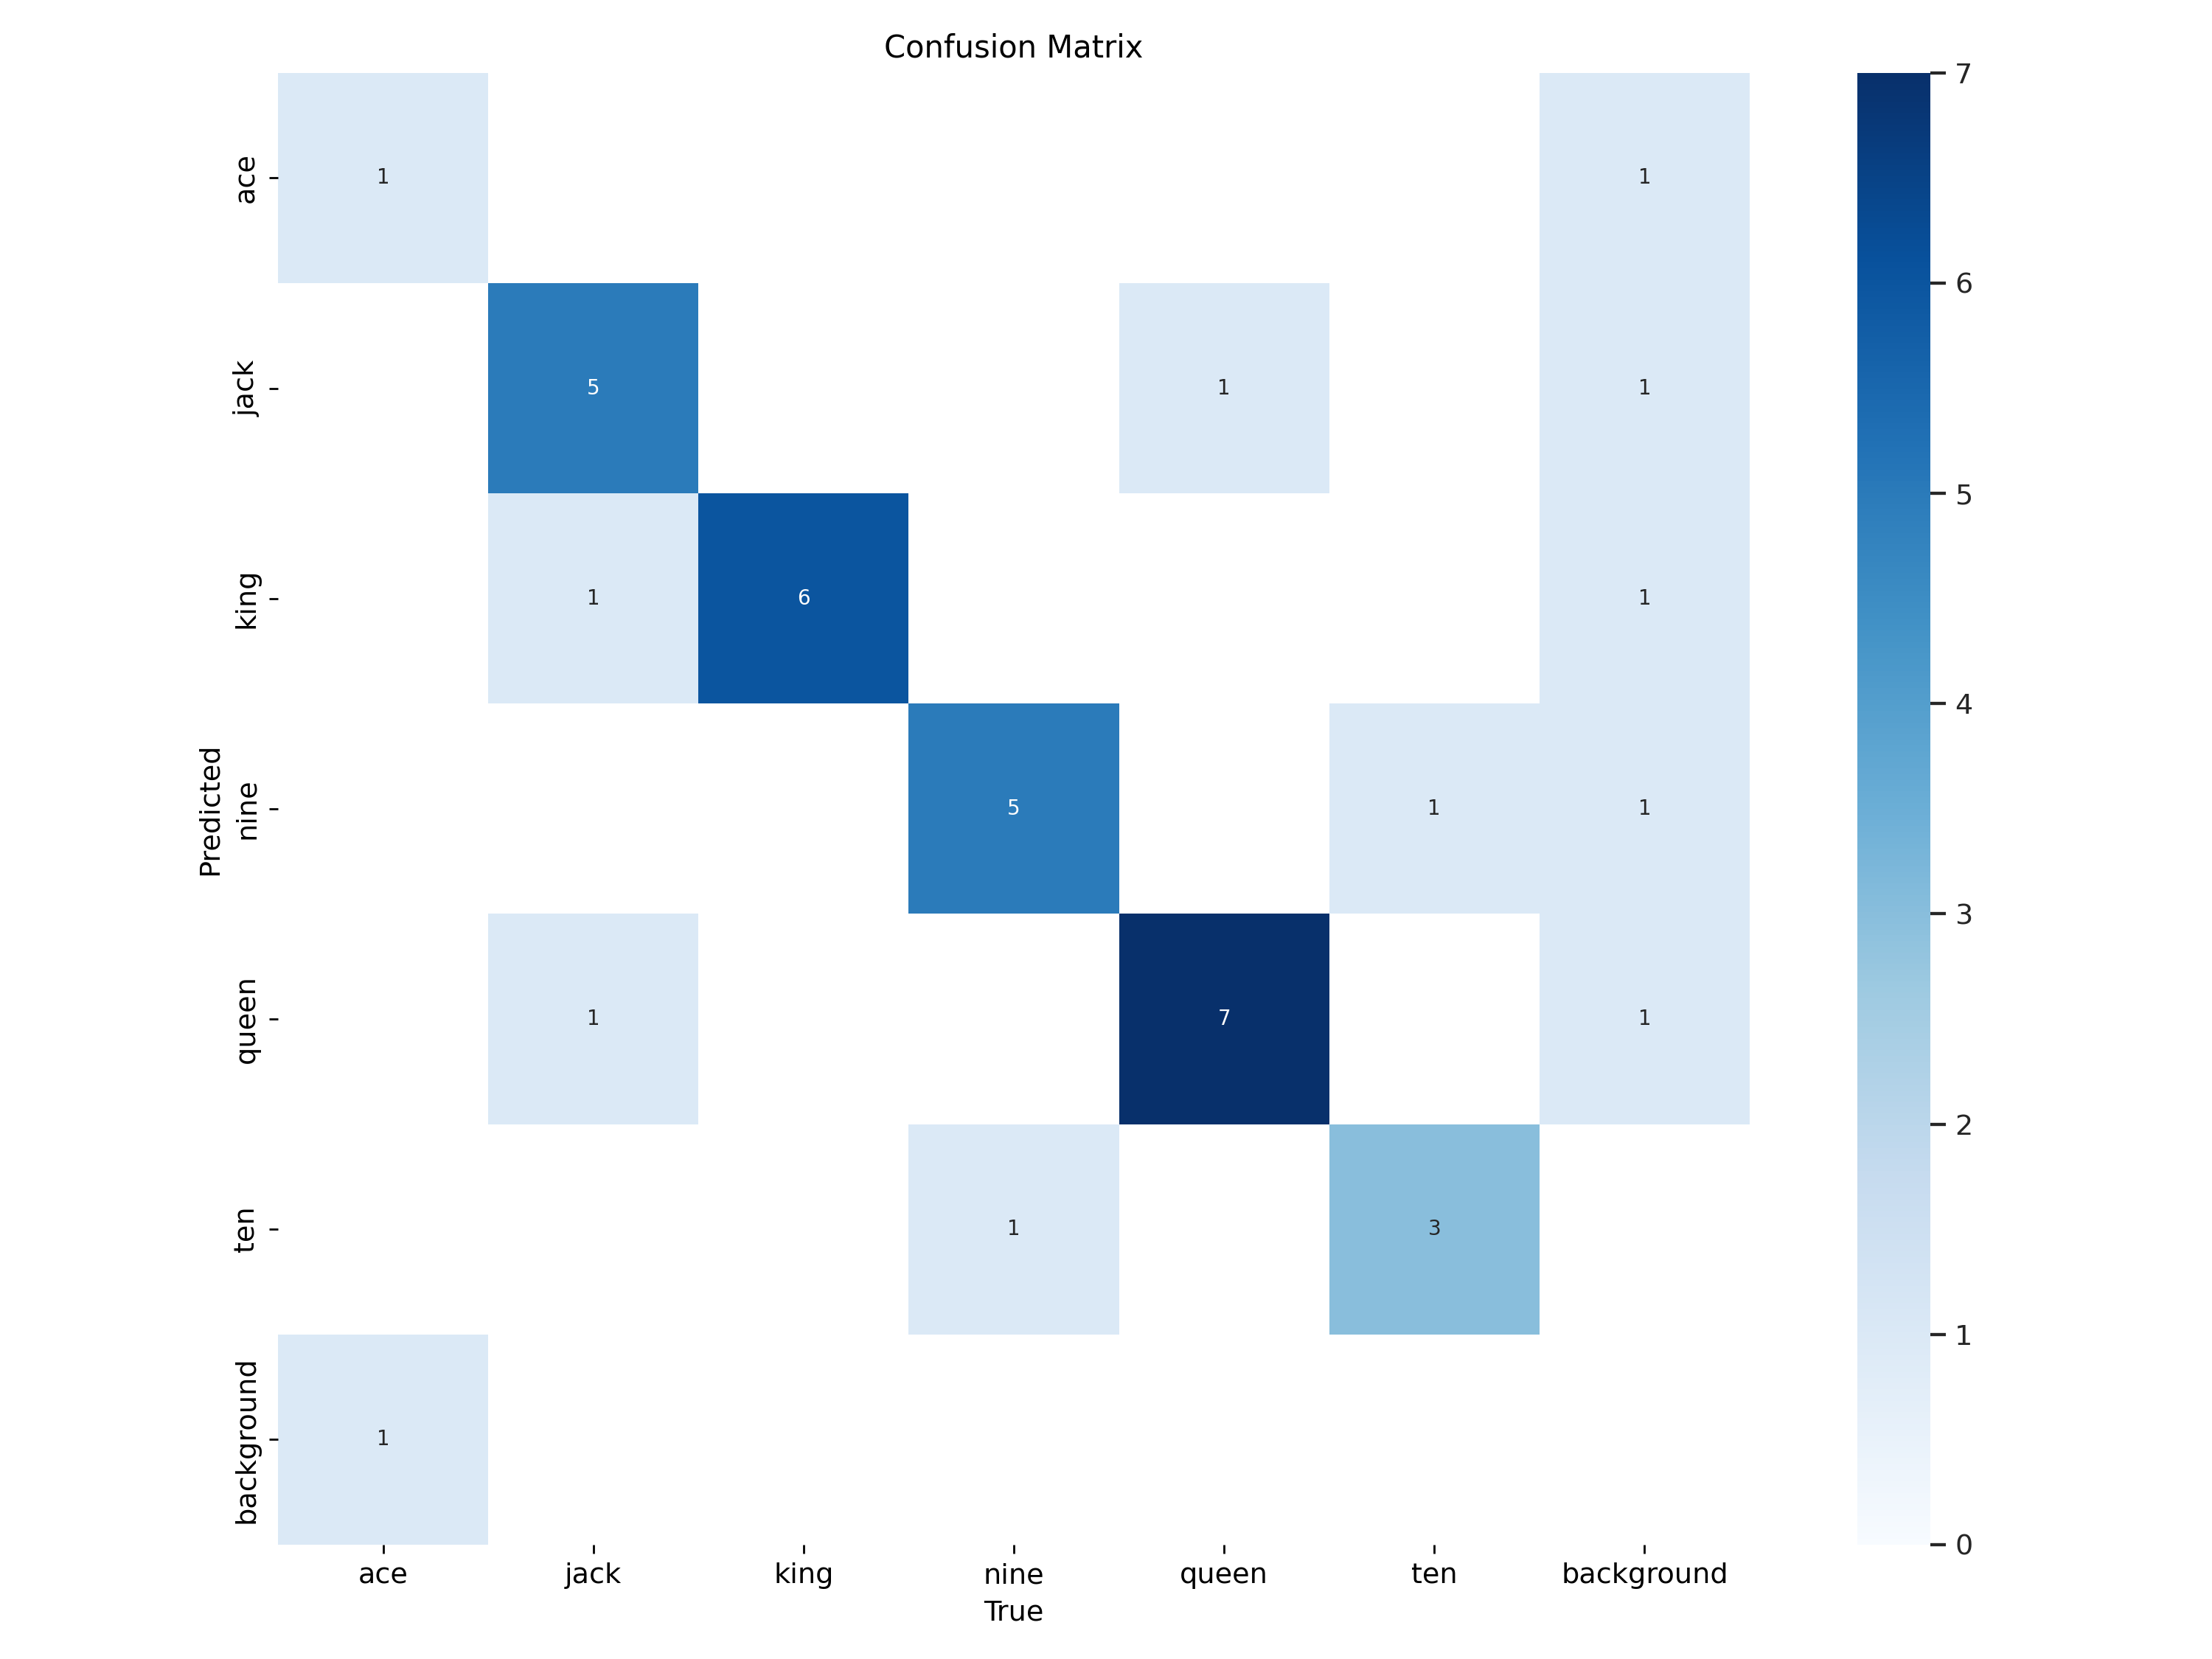

In [21]:
from IPython.display import Image

Image(filename=f'/content/yolov12/runs/detect/train/confusion_matrix.png', width=600)

[Errno 2] No such file or directory: '{HOME}'
/content/yolov12


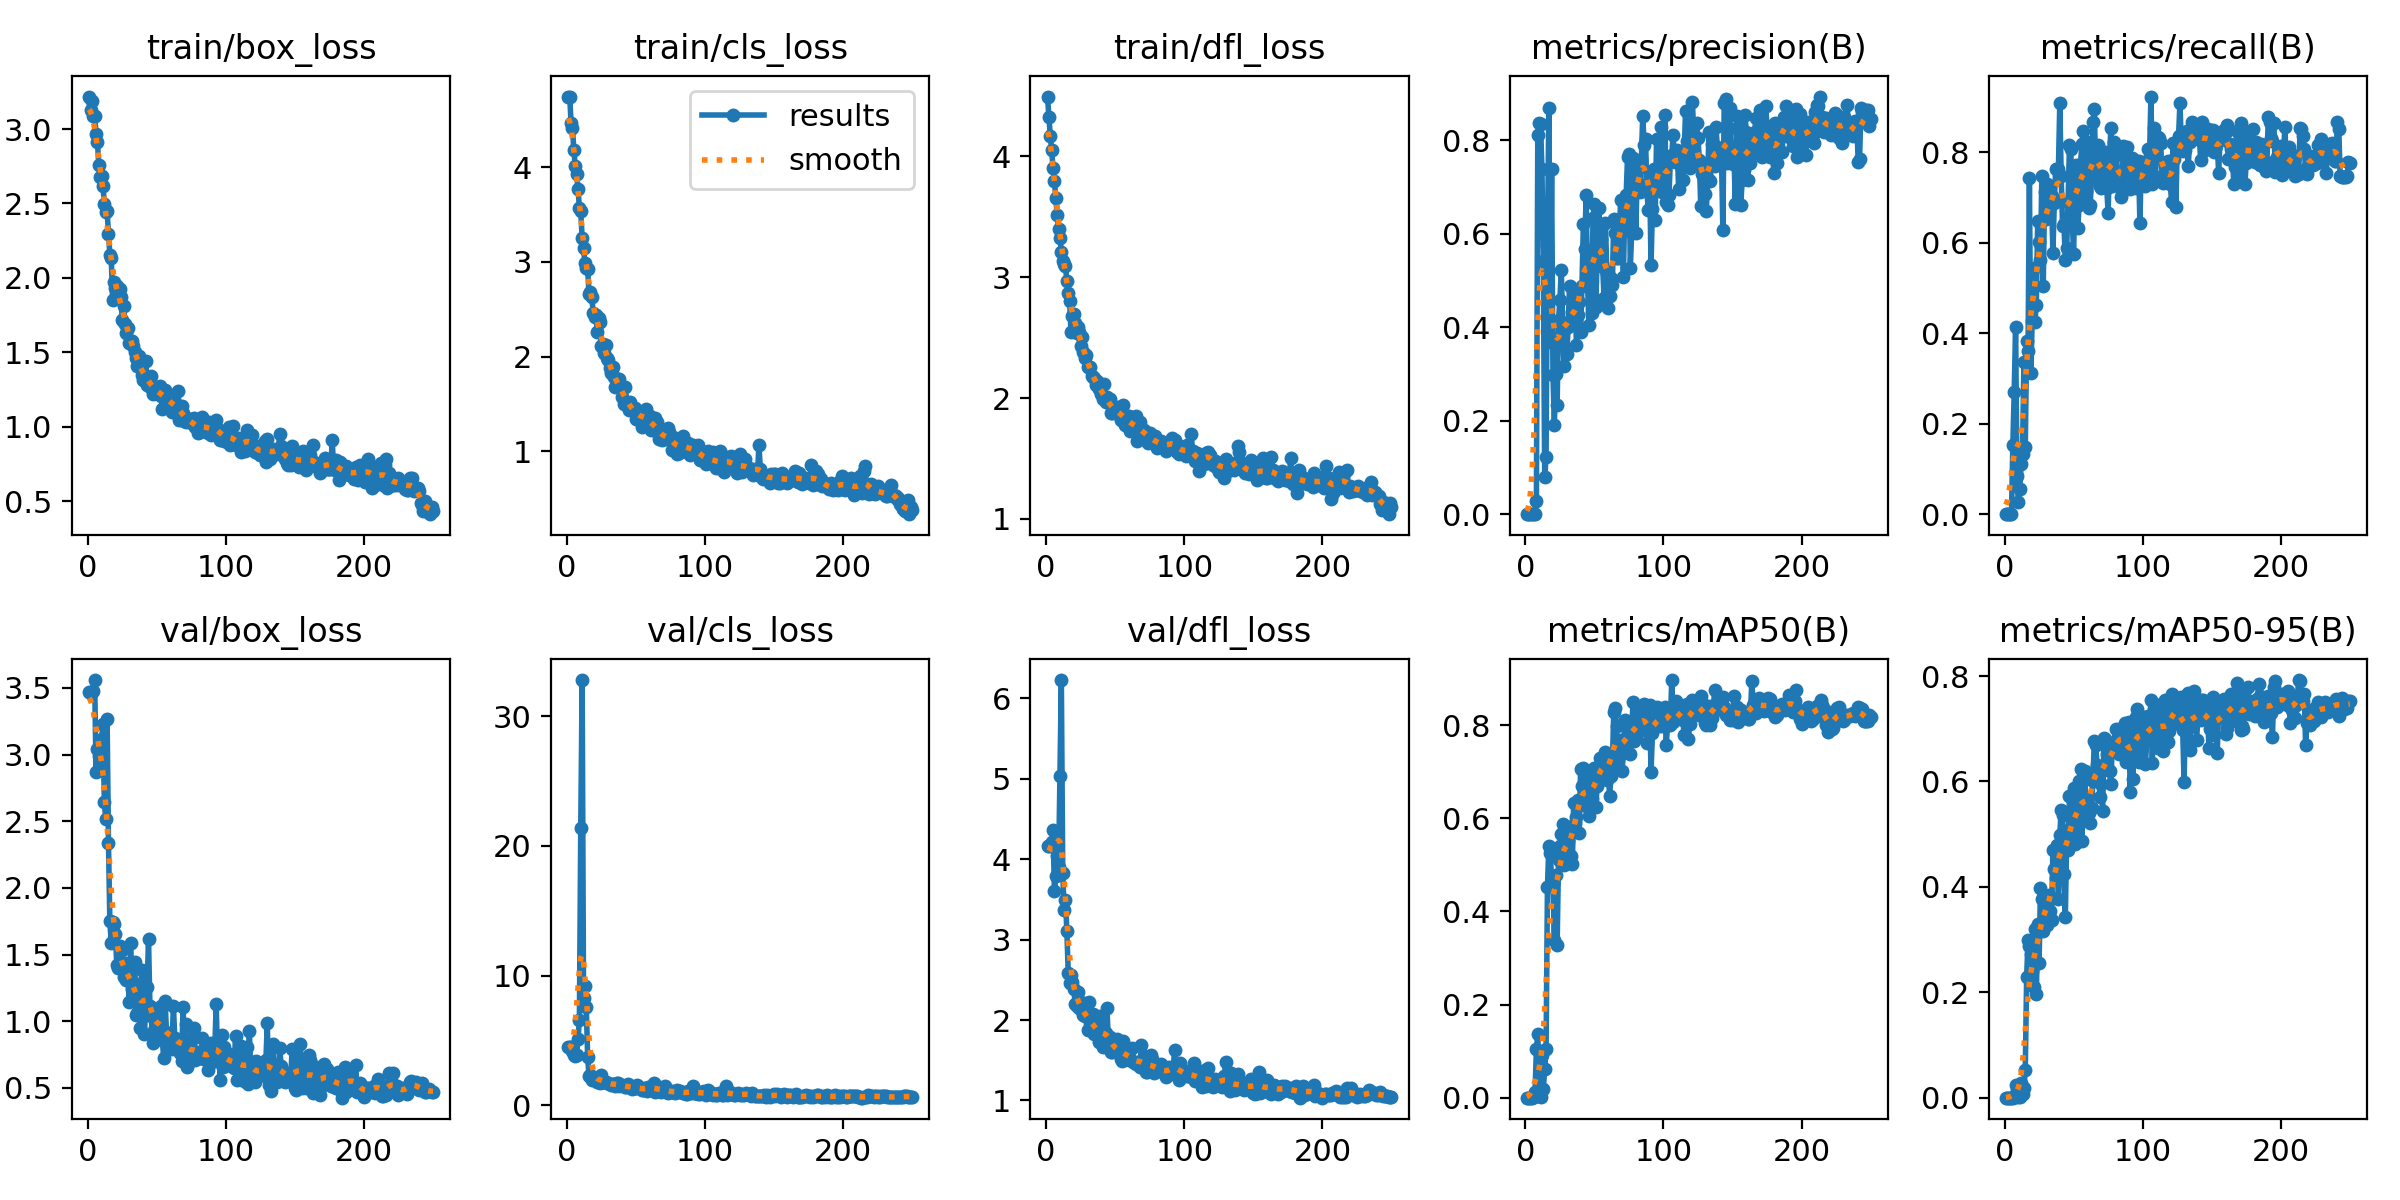

In [23]:
%cd {HOME}
Image(filename=f'/content/yolov12/runs/detect/train/results.png', width=600)

## Run inference with trained model

We can run our trained model on a random image from the `valid` set of our dataset using the following code:

In [25]:
import random

model = YOLO(f"/content/yolov12/runs/detect/train/weights/best.pt")

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)


0: 640x640 1 king, 44.7ms
Speed: 1.9ms preprocess, 44.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


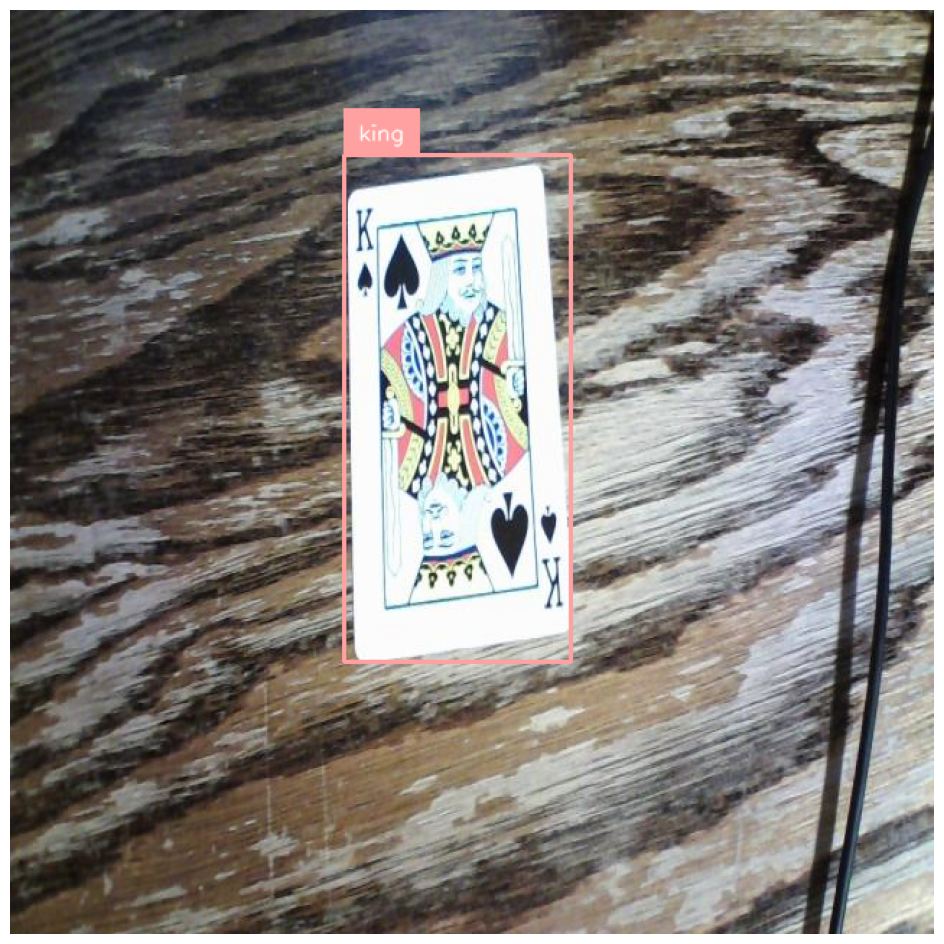

In [29]:
image_paths = list(ds)
image_path, _, _ = random.choice(image_paths)
image = cv2.imread(image_path)

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

results = model(image)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [30]:
%cd /content/yolov12/
!ls -al /content/yolov12/ultralytics/engine/

/content/yolov12
total 304
drwxr-xr-x  3 root root  4096 Sep  2 09:51 .
drwxr-xr-x 13 root root  4096 Sep  2 09:51 ..
-rw-r--r--  1 root root 69155 Sep  2 09:49 exporter.py
-rw-r--r--  1 root root    70 Sep  2 09:49 __init__.py
-rw-r--r--  1 root root 53290 Sep  2 09:49 model.py
-rw-r--r--  1 root root 17740 Sep  2 09:49 predictor.py
drwxr-xr-x  2 root root  4096 Sep  2 09:51 __pycache__
-rw-r--r--  1 root root 75114 Sep  2 09:49 results.py
-rw-r--r--  1 root root 37434 Sep  2 09:49 trainer.py
-rw-r--r--  1 root root 11976 Sep  2 09:49 tuner.py
-rw-r--r--  1 root root 14901 Sep  2 09:49 validator.py


In [31]:
%cd /content/yolov12/
!ls

/content/yolov12
app.py	  dog.jpeg.1  mkdocs.yml	requirements.txt  ultralytics.egg-info
assets	  examples    PokerCard_2023-1	runs		  yolov12n.pt
docker	  LICENSE     pyproject.toml	tests		  yolov12x.pt
dog.jpeg  logs	      README.md		ultralytics


In [32]:
# export ONNX for ONNX inference
model.export(format="onnx", device = 'cpu', half=True, simplify=True)  # or format="onnx" or format="onnx"

Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from '/content/yolov12/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (37.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 326.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 222.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 293.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 274.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 312.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 31.6s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command f

'/content/yolov12/runs/detect/train/weights/best.onnx'

In [33]:
!ls /content/yolov12/runs/detect/train/weights/ -al

total 154484
drwxr-xr-x 2 root root     4096 Sep  2 12:42 .
drwxr-xr-x 3 root root     4096 Sep  2 11:02 ..
-rw-r--r-- 1 root root 78660068 Sep  2 12:42 best.onnx
-rw-r--r-- 1 root root 39758654 Sep  2 11:02 best.pt
-rw-r--r-- 1 root root 39758654 Sep  2 11:02 last.pt


In [34]:
#Copy the weight/structure file to your Google drive (my drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!cp /content/yolov12/runs/detect/train/weights/best.onnx /content/drive/MyDrive/yolov12_best0902.onnx
!cp /content/yolov12/runs/detect/train/weights/best.pt /content/drive/MyDrive/yolov12_best0902.pt
!ls /content/drive/MyDrive *.onnx

# You can implement your local service with "yolov12_best.onnx" file where you have...!!!

ls: cannot access '*.onnx': No such file or directory
/content/drive/MyDrive:
'1. 2023년도 연구센터 평가결과보고서_양식_인공지능혁신연구센터.xlsx'
 1-s2.0-S0141938215000980-main.pdf
 20.09.10_사업자등록증_숙명여대산단.pdf
'2017-publication-9500-3차년도_중간점검(초안)(검토본).pptx'
 2019-CONTEXT-9500-1차년도-연차보고서_김병규교수님연구실_수정본.hwp
'2021년 지역특화산업육성+(R&D)지역주력산업육성 최종평가 보고서-210615-수정본.hwp'
'2024-2 (일반형)캡스톤디자인 결과보고서 양식_김병규.hwp'
'240416_2024년_약자를_위한기술개발_지원사업_과제계획서_숙대내용 보완본.hwp'
 2_별첨_기획처_전체교수회의_발표자료.pdf
'4_별첨3_연구처_세종대 전문가 특강 발표 요약.pdf'
 7BE9317B-6093-42D9-98D2-6F440380AB20.jpeg
'8-2021-138 - 수정_저자교정본(1).hwp'
'8-2021-138 - 수정_저자교정본.hwp'
 AI-and-Blockchain-powered-IoT_CFP.pdf
'A Study on Deep learning-based Hand Drawing Psychological Analysis_final.hwp'
 bus.jpg


In [42]:
##---- Define processing functions -------#
import torchvision
import onnxruntime as ort
import time, random
import torch # Added torch import
import numpy as np # Added numpy import
import cv2 # Added cv2 import

img_size = 640

def box_iou(box1, box2, eps=1e-7):
        # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            box1 (Tensor[N, 4])
            box2 (Tensor[M, 4])
        Returns:
            iou (Tensor[N, M]): the NxM matrix containing the pairwise
                IoU values for every element in boxes1 and boxes2
        """

        # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
        (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
        inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

        # IoU = inter / (area1 + area2 - inter)
        return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

def non_max_suppression(prediction,
            conf_thres,
            iou_thres,
            classes=None,
            agnostic=False,
            multi_label=False,
            labels=(),
            max_det=300,
            nm=0,  # number of masks
    ):
        """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections

        Returns:
            list of detections, on (n,6) tensor per image [xyxy, conf, cls]
        """

        if isinstance(prediction, (list, tuple)):  # YOLOv5 model in validation model, output = (inference_out, loss_out)
            prediction = prediction[0]  # select only inference output

        device = prediction.device
        mps = 'mps' in device.type  # Apple MPS
        if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
            prediction = prediction.cpu()
        bs = prediction.shape[0]  # batch size
        nc = prediction.shape[2] - nm - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Checks
        assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
        assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

        # Settings
        # min_wh = 2  # (pixels) minimum box width and height
        max_wh = 7680  # (pixels) maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 0.5 + 0.05 * bs  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        mi = 5 + nc  # mask start index
        output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
        for xi, x in enumerate(prediction):  # image index, image inference
            # Apply constraints
            # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
            x = x[xc[xi]]  # confidence

            # Cat apriori labels if autolabelling
            if labels and len(labels[xi]):
                lb = labels[xi]
                v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
                v[:, :4] = lb[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box/Mask
            box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
            mask = x[:, mi:]  # zero columns if no masks

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)
            else:  # best class only
                conf, j = x[:, 5:mi].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Apply finite constraint
            # if not torch.isfinite(x).all():
            #     x = x[torch.isfinite(x).all(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence
            else:
                x = x[x[:, 4].argsort(descending=True)]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            if mps:
                output[xi] = output[xi].to(device)
            if (time.time() - t) > time_limit:
                # LOGGER.warning(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
                break  # time limit exceeded

        return output


def xywh2xyxy(x):
        # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
        y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
        y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
        y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
        y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
        y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
        return y

# Read classes.txt
def class_name():
        # UPDATE THIS LIST with the correct class names from your data.yaml file
        classes=['ace', 'king', 'queen', 'jack', 'ten', 'nine']
        return classes

def letterbox(im, color=(114, 114, 114), auto=True, scaleup=True, stride=32):
        # Resize and pad image while meeting stride-multiple constraints
        shape = im.shape[:2]  # current shape [height, width]
        new_shape= img_size
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not scaleup:  # only scale down, do not scale up (for better val mAP)
            r = min(r, 1.0)

        # Compute padding
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

        if auto:  # minimum rectangle
            dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

        dw /= 2  # divide padding into 2 sides
        dh /= 2

        if shape[::-1] != new_unpad:  # resize
            im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
        return im, r, (dw, dh)

# Initialize ONNXRuntime session
def ort_session(onnx_model):
        providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if ort.get_device()=='GPU' else ['CPUExecutionProvider']
        session = ort.InferenceSession(onnx_model, providers=providers)
        print(session.get_providers())

        return session

# Display results
def result(img,ratio, dwdh, out):
        names= class_name()
        colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}
        # Correctly access class ID (assuming it's the last element in the tensor)
        for i,(x0,y0,x1,y1,score,cls_id) in enumerate(out):
            box = np.array([x0,y0,x1,y1])
            box -= np.array(dwdh*2)
            box /= ratio
            box = box.round().astype(np.int32).tolist()
            # Extract the class ID from the last element which is a tensor
            cls_id = int(cls_id.argmax()) # Use argmax to get the index of the highest score
            print("Class id :", cls_id)
            # Add a check to ensure cls_id is within the valid range
            if 0 <= cls_id < len(names):
                score = round(float(score),3)
                name = names[cls_id]
                color = colors[name]
                name += ' '+str(score)
                cv2.rectangle(img,box[:2],box[2:],color,2)
                cv2.putText(img,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)
            else:
                print(f"Invalid class ID {cls_id}, skipping detection.")
                continue
        return img
        # cv2.imwrite('v5_onnx.jpg', img)
        # cv2.imshow('result',img)
        # cv2.waitKey(0)

In [47]:
!cp /content/drive/MyDrive/cam_image51.jpg .
!ls -al
!pwd

total 123184
drwxr-xr-x 12 root root      4096 Sep  2 12:52 .
drwxr-xr-x  1 root root      4096 Sep  2 12:43 ..
-rw-r--r--  1 root root      5674 Sep  2 09:49 app.py
drwxr-xr-x  2 root root      4096 Sep  2 09:49 assets
-rw-------  1 root root    165488 Sep  2 12:52 cam_image51.jpg
-rw-------  1 root root    156014 Sep  2 12:50 cam_image52.jpg
drwxr-xr-x  2 root root      4096 Sep  2 09:49 docker
-rw-r--r--  1 root root    106055 Jun  2  2023 dog.jpeg
-rw-r--r--  1 root root    106055 Jun  2  2023 dog.jpeg.1
drwxr-xr-x 16 root root      4096 Sep  2 09:49 examples
drwxr-xr-x  8 root root      4096 Sep  2 09:49 .git
-rw-r--r--  1 root root     34523 Sep  2 09:49 LICENSE
drwxr-xr-x  2 root root      4096 Sep  2 09:49 logs
-rw-r--r--  1 root root     36633 Sep  2 09:49 mkdocs.yml
drwxr-xr-x  5 root root      4096 Sep  2 09:56 PokerCard_2023-1
-rw-r--r--  1 root root      7892 Sep  2 09:49 pyproject.toml
-rw-r--r--  1 root root     13992 Sep  2 09:49 README.md
-rw-r--r--  1 root root       

In [38]:
!ls /content/yolov12/runs/detect/train/weights/ -al

total 154484
drwxr-xr-x 2 root root     4096 Sep  2 12:42 .
drwxr-xr-x 3 root root     4096 Sep  2 11:02 ..
-rw-r--r-- 1 root root 78660068 Sep  2 12:42 best.onnx
-rw-r--r-- 1 root root 39758654 Sep  2 11:02 best.pt
-rw-r--r-- 1 root root 39758654 Sep  2 11:02 last.pt


['CUDAExecutionProvider', 'CPUExecutionProvider']
Predictions: tensor([[ 6.2280e+01,  4.9992e+01,  1.6759e+02,  1.5975e+02,  6.3357e+04,  8.1730e+03],
        [-5.2286e+00, -1.9969e+00,  1.6487e+01,  2.9159e+01,  2.6129e+04,  2.9540e+03],
        [ 5.1075e+01,  2.4671e+01,  9.2720e+01,  6.5323e+01,  2.2744e+04,  8.1730e+03],
        [ 3.5660e+00,  3.5127e+00,  1.2058e+01,  1.3098e+01,  6.5877e+03,  6.3940e+03]])
yolov12 ONNXRuntime Inference Time: 1.5323238372802734
Number of class names: tensor([[ 6.2280e+01,  4.9992e+01,  1.6759e+02,  1.5975e+02,  6.3357e+04,  8.1730e+03],
        [-5.2286e+00, -1.9969e+00,  1.6487e+01,  2.9159e+01,  2.6129e+04,  2.9540e+03],
        [ 5.1075e+01,  2.4671e+01,  9.2720e+01,  6.5323e+01,  2.2744e+04,  8.1730e+03],
        [ 3.5660e+00,  3.5127e+00,  1.2058e+01,  1.3098e+01,  6.5877e+03,  6.3940e+03]]) 1
Class id : 0
Class id : 0
Class id : 0
Class id : 0


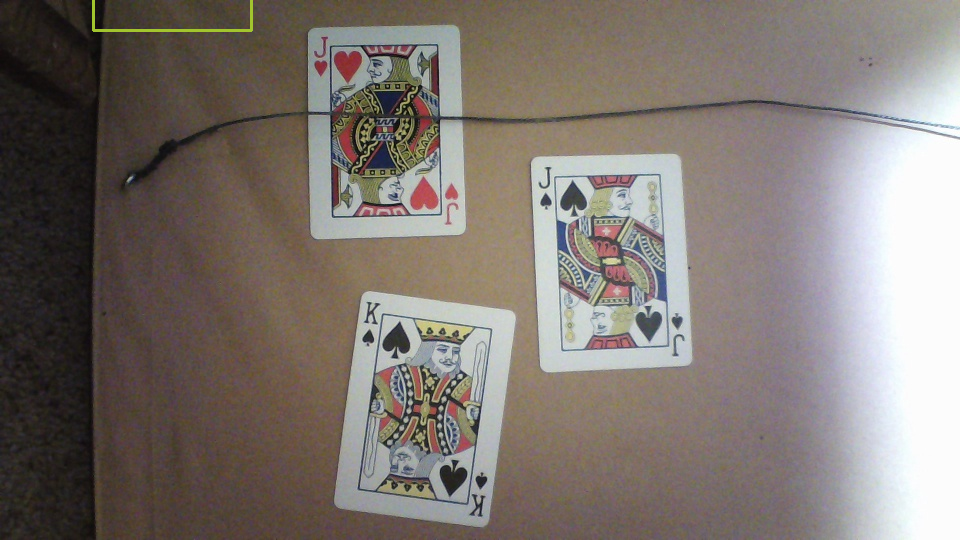

In [48]:
# Inference for ONNX model
import torch
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

cuda = True
w = "/content/yolov12/runs/detect/train/weights/best.onnx"
img = cv2.imread('/content/yolov12/cam_image51.jpg')
image, ratio, dwdh = letterbox(img, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)
im = image.astype(np.float32)
im /= 255

#onnxruntime session
session= ort_session(w)
outname = [i.name for i in session.get_outputs()]
inname = [i.name for i in session.get_inputs()]

# print('input-output names:',inname,outname)
inp = {inname[0]:im}

# ONNXRuntime inference
t1 = time.time()
outputs = session.run(outname, inp)[0]
t2 = time.time()
output= torch.from_numpy(outputs)
out = non_max_suppression(output, conf_thres=0.25, iou_thres=0.45)[0]
print('Predictions:',out)
print('yolov12 ONNXRuntime Inference Time:', t2-t1)
print('Number of class names:', out, len(outname))
imgout=result(img, ratio, dwdh, out)
cv2.imwrite('result.jpg', imgout)
# print('result', img.shape)
# cv2.imshow('result',img)
# cv2.waitKey(0)
cv2_imshow(imgout)

Our model successfully identified objects in our image.

## 🏆 Congratulations

